# Analysis of meta-reinforcement learning model of prefrontal cortex 

This notebook provides descriptions, visualizations, and interpretations of results from experiments with a meta-reinforcement learning model of the prefrontal cortex. The original idea comes from a paper from Google DeepMind (including Botvinick):

Wang et al. (2018) Prefrontal cortex as a meta-reinforcement learning system. *Nature Neuroscience*

In the paper, the authors describe a model of the prefrontal cortex that is a meta-reinforcement learner, i.e. the prefrontal cortex is hypothesized to learn, at a long timescale through synaptic changes in response to dopamine reward prediction errors, a stand-alone reinforcement learning algorithm that itself makes value predictions and updates, solves the explore-exploit problem, etc. In this model, unlike in traditional models of the role of the prefrontal cortex in reinforcement learning, the dopamine system trains the weights of the prefrontal cortex to implement a separate reinforcement-learning algorithm, which can learn and update its value function at a much shorter timescale through the activity dynamics of the network.

The PFC is modeled as an LSTM, with current state, previous action, and previous reward as inputs, and actions and value predictions as outputs. It is trained with Advantage Actor Critic, as detailed in another paper from DeepMind: 

Mnih et al. (2016). Asynchronous methods for deep reinforcement learning. *ICML*

This notebook outlines experiments with models built in PyTorch that replicate some of the findings from the Wang et al. (2018) paper (in particular, figure 5), and presents results from additional experiments on new environments.

### General thoughts about the meta-reinforcement learning paradigm

The meta-reinforcement learning perspective offers some theoretical advantages over the traditional reinforcement learning models in psychology and neuroscience:
* Modeling paradigm explicitly includes prior experience: Traditional models of human reinforcement learning have to assume that participants come into the lab as blank slates with randomly initialized reward/transiton functions, but clearly this is highly unrealistic. The metaRL framework explicitly defines the prior experience of the subject before they come into the lab.
* MetaRL is a more realistic model of how human participants actually learn a task in the lab (i.e. not with DA-driven synaptic weight changes, which should be taking place on a much slower timescale over the course of development). Rather, learning occurs through the dynamics of PFC activity itself, which have been shaped on slower timescales to cope with the explore/exploit tradeoff, optimize the resources necessary for a given task, etc.
    * For example, traditional RL algorithms don't explicitly model the working memory demands required just to learn and update during the course of a task
* Emergent temporal abstraction: as opposed to, e.g., the successor representation or the options framework, which explicitly define the temporally abstract representations that will be used by a model, if temporal abstraction is used by a metaRL model it will be because it emerged spontaneously in the course of learning a task. 
    * For example, if metaRL algorithm is run on the same environments used in the cluster-SR simulations, temporally abstract representations that capture the structure of the environment would probably emerge. So the main characteristics motivating the successor representation and the cluster-SR algorithm (i.e. temporal abstraction, natural representation of environment structure, computational efficiency (no tree search), reduced working memory demands involved in memorizing optimal policy, etc.) would probably naturally emerge, without having assumed a fixed model of temporal abstraction.
* Natural model of latent-variable tracking

#### Imports

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from IPython.display import Image
from sklearn.manifold import MDS
from matplotlib.lines import Line2D

## Two-step task

One of the tasks experimented with in the Wang et al. (2018) paper is a classic task used to investigate reinforcement learning in neuroscience and psychology called the two-step task. The task is a simple two-step Markov Decision Process (see figure a below).

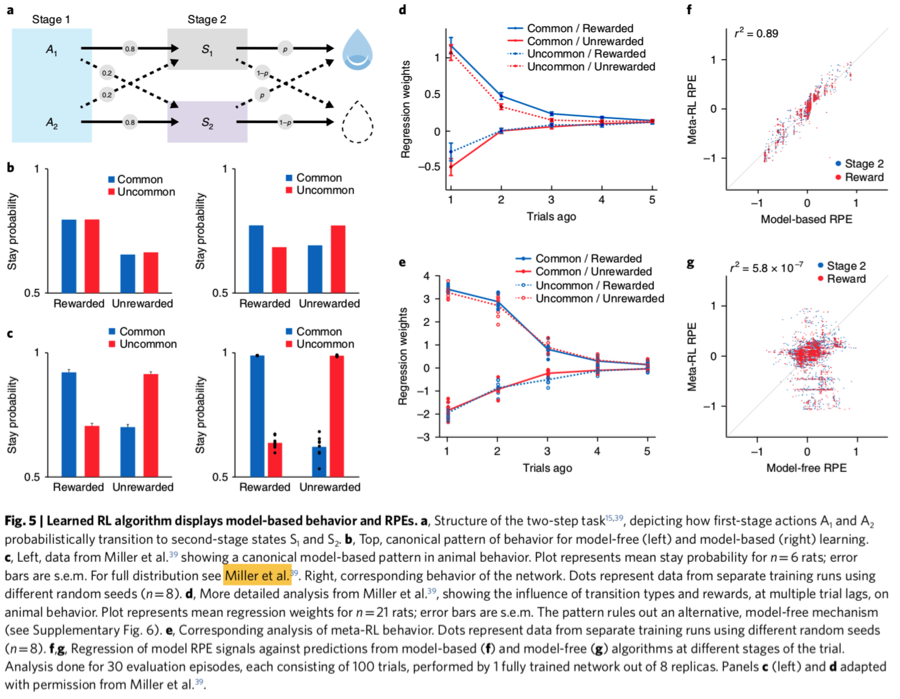

In [2]:
Image(filename='../Documents/Wang_et_al_2018_figure5.png') 

Here we simply replicate the results from the figure above. The model, environment, and training/testing scripts were built from scratch using PyTorch. 

### Training results

In [4]:
with open('../data/train_LSTM_two_step.json','r') as f:
    data = json.load(f)

In [5]:
total_rewards = data['total_rewards']
total_rewards_smooth = savgol_filter(total_rewards, 30001, 2)

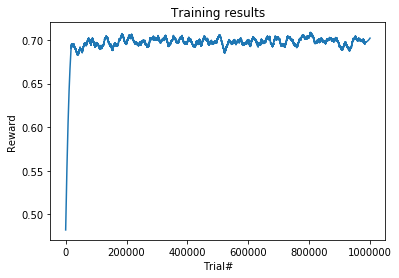

In [6]:
#plt.plot(total_rewards, 'o')
plt.plot(total_rewards_smooth)
plt.title('Training results')
plt.xlabel('Trial#')
plt.ylabel('Reward')
plt.show()

In [7]:
print("Average reward per trial over the whole course of training:", np.mean(total_rewards))

Average reward per trial over the whole course of training: 0.696397


### Testing results

In [8]:
col_names = ['Episode','Trial','T','State','Action','Reward','Rewarded_state']
test_data = np.load('../data/test_LSTM_two_step.npy')
test_data = pd.DataFrame(test_data,columns=col_names)

test_two_step.py writes an output file in the form of a numpy array with data for each time step on a separate row, and the following columns:
1. Episode
2. Trial
3. T (timestep in trial)
4. State
5. Action
6. Reward
7. Rewarded_state

In [9]:
# Average reward received per trial
print("Average reward per trial: ", np.mean(test_data.loc[(test_data['T'] == 3.0)]['Reward']))

Average reward per trial:  0.6992666666666667


#### Visualize how actions of model are sensitive to rewarded state

In [10]:
# Get data from only first timestep of every trial, for three random episodes
random_episodes = np.random.randint(0,300,3).astype(float)
E0_T1 = test_data.loc[(test_data['T'] == 1.0) & (test_data['Episode'] == random_episodes[0])]
E1_T1 = test_data.loc[(test_data['T'] == 1.0) & (test_data['Episode'] == random_episodes[1])]
E2_T1 = test_data.loc[(test_data['T'] == 1.0) & (test_data['Episode'] == random_episodes[2])]

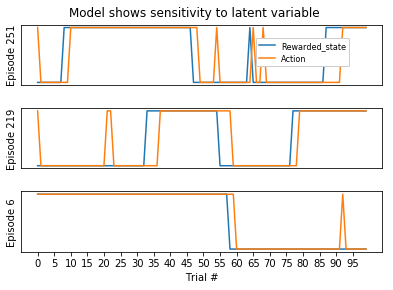

In [11]:
fig,axs = plt.subplots(3,1,sharey=True)
fig.tight_layout(pad=2.0, w_pad=0.0, h_pad=0.2)

axs[0].plot(E0_T1['Rewarded_state'])
axs[0].plot(E0_T1['Action'] + 1.0)
axs[0].set_ylabel('Episode %.0f' % random_episodes[0])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].plot(E1_T1['Rewarded_state'])
axs[1].plot(E1_T1['Action'] + 1.0)
axs[1].set_ylabel('Episode %.0f' % random_episodes[1])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].plot(E2_T1['Rewarded_state'])
axs[2].plot(E2_T1['Action'] + 1.0)
axs[2].set_ylabel('Episode %.0f' % random_episodes[2])
xticks = [i for i in E2_T1.index if i % 5*3 == 0]
labels = 5*np.arange(len(xticks))
axs[2].set_xticks(xticks)
axs[2].set_xticklabels(labels)
axs[2].set_xlabel('Trial #')
axs[2].set_yticks([])

fig.legend(['Rewarded_state','Action'],loc=[0.65,0.77],prop={'size': 8},framealpha=1.0)
fig.suptitle('Model shows sensitivity to latent variable')
plt.show()

This figure shows that the model has adapted to the existence of the latent variable in the environment which determines which state, and therefore which action, is rewarded on a given trial. As can be seen in the figure, when the rewarded state in the environment changes, the model quickly adapts in real time to the difference in the reward structure, even though the synaptic weights of the model have been frozen for testing. 

#### Model-based vs. model-free behavior

Create new dataframe with a row for each trial, and the following columns:
1. Episode
2. Trial
3. Previous_transition: True if transition on previous trial was common, False if uncommon
4. Previous_reward: True if model was rewarded on previous trial, False otherwise
5. Stay: True if the model chose the same action as the previous trial, False otherwise

In [12]:
# Take only first timestep from original dataframe
MBMF_df = test_data.loc[(test_data['T'] == 1.0)][['Episode','Trial','Action']]
# Rename rows
ntrials = MBMF_df.shape[0]
mapping = {3*i:i for i in range(ntrials)}
MBMF_df = MBMF_df.rename(mapping,axis='index')
# Add new columns
MBMF_df['Stay'] = pd.Series([np.nan for i in range(ntrials)])
MBMF_df['Previous_transition'] = pd.Series([np.nan for i in range(ntrials)])
MBMF_df['Previous_reward'] = pd.Series([np.nan for i in range(ntrials)])

In [13]:
# Compute 'stay' using vectorized computations
a = np.array(MBMF_df['Action'])
a_prev = np.append(np.nan,np.array(MBMF_df['Action'])[0:-1])
stay = (a_prev == a)
MBMF_df['Stay'] = stay

In [14]:
# Compute 'previous_transition' using vectorized computations
a = np.array(test_data[(test_data['T'] == 1.0)]['Action'])
s = np.array(test_data[(test_data['T'] == 2.0)]['State'])
trans = np.logical_or(np.logical_and(a == 0.0,s == 1.0),np.logical_and(a == 1.0,s == 2.0))
prev_trans = np.append(np.array(False),trans[0:-1])
MBMF_df['Previous_transition'] = prev_trans

In [15]:
# Compute 'previous_reward'
r = np.array(test_data[(test_data['T'] == 3.0)]['Reward'])
prev_r = np.append(np.array(0.0),r[0:-1])
MBMF_df['Previous_reward'] = prev_r

In [16]:
# Remove first trial of every episode
MBMF_df = MBMF_df[MBMF_df['Trial'] != 0.0]

In [17]:
# Compute four means
stay_cr = np.mean(MBMF_df[(MBMF_df['Previous_transition'] == True) & (MBMF_df['Previous_reward'] == True)]['Stay'])
stay_ur = np.mean(MBMF_df[(MBMF_df['Previous_transition'] == False) & (MBMF_df['Previous_reward'] == True)]['Stay'])
stay_cu = np.mean(MBMF_df[(MBMF_df['Previous_transition'] == True) & (MBMF_df['Previous_reward'] == False)]['Stay'])
stay_uu = np.mean(MBMF_df[(MBMF_df['Previous_transition'] == False) & (MBMF_df['Previous_reward'] == False)]['Stay'])

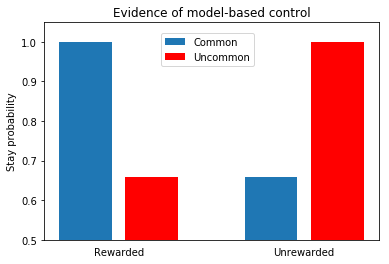

In [18]:
# Plot four means
width = 0.2 # width of the bars
space = 0.05 # space between bars in each group
fig,ax = plt.subplots()
ax.bar(0,stay_cr,width=width,color='tab:blue')
ax.bar(0+width+space,stay_ur,width=width,color='r')
ax.bar(0.7,stay_cu,width=width,color='tab:blue')
ax.bar(0.7+width+space,stay_uu,width=width,color='r')
ax.set_ylim([0.5,None])
ax.set_xticks([(width+space)/2,0.7+(width+space)/2])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(['Rewarded','Unrewarded'])
ax.set_ylabel('Stay probability')
ax.set_title('Evidence of model-based control')
ax.legend(['Common','Uncommon'],loc=[0.35,0.8])
plt.show()

As can be seen in the figure above, the model shows evidence of "model-based" control in that it takes previous state information into account before making decisions (i.e. the choice on a given trial depends not only on whether the model was rewarded in the previous trial, but also whether a common or uncommon transition occurred in the previous trial). This is associated with "model-based" control because in the traditional model-based algorithm, a tree-search is conducted before making decisions, allowing the model to differentiate between punishments received from uncommon transitions and those received due to reward reversals. 

## Rocket task

This task is very similar to the two-step task described above, in that it is a two-step Markov Devicision process. The difference is that in this task, there are two possible starting states, and transitions and rewards are deterministic, except that there are stochastic reward reversals, where the rewarded state changes, and stochastic transition reversals, where the transition structure changes.

The same model used above, and described in the Wang et al. (2018) paper, was used on this task, and trained on the following three Rocket-task environments:
1. Rocket task with no reversals (simulating practice)
2. Rocket task with reward reversals only
3. Rocket task with transition reversals only
4. Rocket task with both transition and reward reversals

Each of the three resulting models were then tested on all three environments.

### Training results

In [19]:
with open('results/train_rocket_none.json','r') as f:
    train_rocket_none_data = json.load(f)
with open('results/train_rocket_reward.json','r') as f:
    train_rocket_reward_data = json.load(f)
with open('results/train_rocket_transition.json','r') as f:
    train_rocket_transition_data = json.load(f)
with open('results/train_rocket_both.json','r') as f:
    train_rocket_both_data = json.load(f)

In [20]:
train_rocket_none_data = train_rocket_none_data['total_rewards']
train_rocket_reward_data = train_rocket_reward_data['total_rewards']
train_rocket_transition_data = train_rocket_transition_data['total_rewards']
train_rocket_both_data = train_rocket_both_data['total_rewards']
train_rocket_none_data_smooth = savgol_filter(train_rocket_none_data, 30001, 2)
train_rocket_reward_data_smooth = savgol_filter(train_rocket_reward_data, 30001, 2)
train_rocket_transition_data_smooth = savgol_filter(train_rocket_transition_data, 30001, 2)
train_rocket_both_data_smooth = savgol_filter(train_rocket_both_data, 30001, 2)

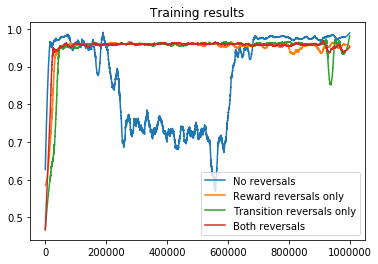

In [21]:
plt.plot(train_rocket_none_data_smooth)
plt.plot(train_rocket_reward_data_smooth)
plt.plot(train_rocket_transition_data_smooth)
plt.plot(train_rocket_both_data_smooth)
plt.title('Training results')
plt.legend(['No reversals','Reward reversals only', 'Transition reversals only', 'Both reversals'])
plt.show()

### Testing results

Import testing results and set up dataframes:

In [22]:
# Load testing results
test_rocket_none_reward = np.load('results/test_rocket_none_on_rocket_reward.npy')
test_rocket_none_transition = np.load('results/test_rocket_none_on_rocket_transition.npy')
test_rocket_none_both = np.load('results/test_rocket_none_on_rocket_both.npy')

test_rocket_reward_reward = np.load('results/test_rocket_reward_on_rocket_reward.npy')
test_rocket_reward_transition = np.load('results/test_rocket_reward_on_rocket_transition.npy')
test_rocket_reward_both = np.load('results/test_rocket_reward_on_rocket_both.npy')

test_rocket_transition_reward = np.load('results/test_rocket_transition_on_rocket_reward.npy')
test_rocket_transition_transition = np.load('results/test_rocket_transition_on_rocket_transition.npy')
test_rocket_transition_both = np.load('results/test_rocket_transition_on_rocket_both.npy')

test_rocket_both_reward = np.load('results/test_rocket_both_on_rocket_reward.npy')
test_rocket_both_transition = np.load('results/test_rocket_both_on_rocket_transition.npy')
test_rocket_both_both = np.load('results/test_rocket_both_on_rocket_both.npy')

In [23]:
# Set up pandas dataframes
col_names = ['Episode','Trial','T','State','Action','Reward','Rewarded_state', 'Transition_regime']

test_rocket_none_reward = pd.DataFrame(test_rocket_none_reward,columns=col_names)
test_rocket_none_transition = pd.DataFrame(test_rocket_none_transition,columns=col_names)
test_rocket_none_both = pd.DataFrame(test_rocket_none_both,columns=col_names)

test_rocket_reward_reward = pd.DataFrame(test_rocket_reward_reward,columns=col_names)
test_rocket_reward_transition = pd.DataFrame(test_rocket_reward_transition,columns=col_names)
test_rocket_reward_both = pd.DataFrame(test_rocket_reward_both,columns=col_names)

test_rocket_transition_reward = pd.DataFrame(test_rocket_transition_reward,columns=col_names)
test_rocket_transition_transition = pd.DataFrame(test_rocket_transition_transition,columns=col_names)
test_rocket_transition_both = pd.DataFrame(test_rocket_transition_both,columns=col_names)

test_rocket_both_reward = pd.DataFrame(test_rocket_both_reward,columns=col_names)
test_rocket_both_transition = pd.DataFrame(test_rocket_both_transition,columns=col_names)
test_rocket_both_both = pd.DataFrame(test_rocket_both_both,columns=col_names)

In [24]:
# Master list of all test dataframes for rocket task:
test_rocket_df_list = [test_rocket_none_reward,
                       test_rocket_none_transition,
                       test_rocket_none_both,
                       test_rocket_reward_reward,
                       test_rocket_reward_transition,
                       test_rocket_reward_both,
                       test_rocket_transition_reward,
                       test_rocket_transition_transition,
                       test_rocket_transition_both,
                       test_rocket_both_reward,
                       test_rocket_both_transition,
                       test_rocket_both_both]

#### Average reward for each test

In [25]:
rocket_ave_rewards = [np.mean(df[(df['T'] == 3.0)]['Reward']) for df in test_rocket_df_list]
rocket_test_labels = ['N \nR','N \nT','N \nB','R \nR','R \nT','R \nB','T \nR','T \nT','T \nB','B \nR','B \nT','B \nB']


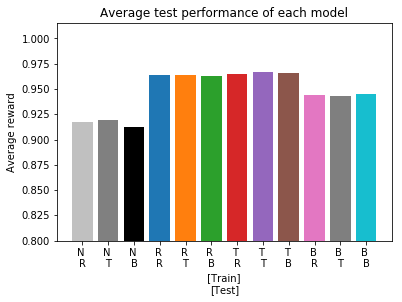

In [26]:
x = np.arange(12)
plt.tick_params(axis='both', labelsize=10)
plt.bar(x,rocket_ave_rewards, color=['silver','grey','black','tab:blue','tab:orange','tab:green','tab:red','tab:purple', 
                                     'tab:brown','tab:pink','tab:gray','tab:cyan'])
plt.xticks(x,rocket_test_labels)
plt.title('Average test performance of each model')
plt.ylabel('Average reward')
plt.ylim([0.8,None])
plt.xlabel(' [Train] \n[Test]')
plt.show()

#### Reward reversal generalization:

In [27]:
rocket_reward_df_list = [test_rocket_none_reward,
                         test_rocket_reward_reward,
                         test_rocket_transition_reward,
                         test_rocket_both_reward]
reward_generalization_results = []
first_reward_generalization_results = []
for df in rocket_reward_df_list:
    trial_df = pd.DataFrame(df.loc[(df['T'] == 3.0)]['Reward'])
    trial_df['Trial'] = np.array(df.loc[(df['T'] == 3.0)]['Trial'])
    trial_df['Start state'] = np.array(df.loc[(df['T'] == 1.0)]['State'])
    
    rew_state = np.array(df.loc[(df['T'] == 3.0)]['Rewarded_state'])
    rew_state_prev = np.append(np.nan,rew_state[:-1])
    rew_reversal = (rew_state != rew_state_prev)
    trial_df['Reward reversal'] = rew_reversal
    
    trial_df['Reward generalization'] = False
    trial_df['First reward generalization'] = False
    trial_df = trial_df.loc[(trial_df['Trial'] != 0.0)] # Get rid of first trial of each episode
    first_rg = True # first reward generalization trial of this episode
    after_reversal = False
    prev_row = trial_df.index[0]
    for row in trial_df.index:
        if trial_df['Trial'][row] < trial_df['Trial'][prev_row]: # Check if we're in a new episode
            first_rg = True
        if trial_df['Reward reversal'][row]:
            after_reversal = True
            start = trial_df['Start state'][row]
            continue
        if after_reversal:
            if trial_df['Start state'][row] != start:
                trial_df.loc[row,'Reward generalization'] = True
                after_reversal = False
            if first_rg:
                trial_df.loc[row,'First reward generalization'] = True
                first_rg = False
        prev_row = row
    reward_generalization_results.append(np.mean(trial_df.loc[(trial_df['Reward generalization'])]['Reward']))
    first_reward_generalization_results.append(np.mean(trial_df.loc[(trial_df['First reward generalization'])]['Reward']))
    

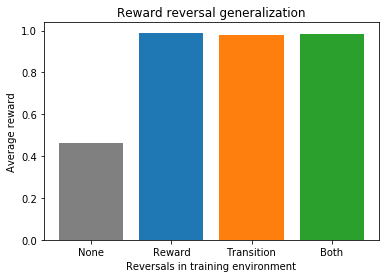

In [28]:
x = np.arange(4)
plt.bar(x,reward_generalization_results, color=['grey','tab:blue','tab:orange','tab:green'])
plt.xticks(x,['None','Reward', 'Transition', 'Both'])
plt.title('Reward reversal generalization')
plt.ylabel('Average reward')
plt.xlabel('Reversals in training environment')
plt.show()

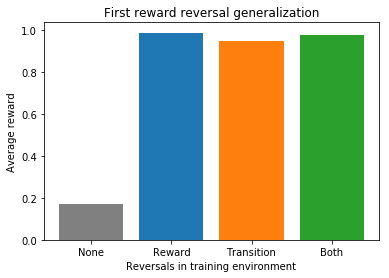

In [29]:
x = np.arange(4)
plt.bar(x,first_reward_generalization_results, color=['grey','tab:blue','tab:orange','tab:green'])
plt.xticks(x,['None','Reward', 'Transition', 'Both'])
plt.title('First reward reversal generalization')
plt.ylabel('Average reward')
plt.xlabel('Reversals in training environment')
plt.show()

#### Transition reversal generalization:

In [30]:
rocket_transition_df_list = [test_rocket_none_transition,
                             test_rocket_reward_transition,
                             test_rocket_transition_transition,
                             test_rocket_both_transition]
transition_generalization_results = []
first_transition_generalization_results = []
for df in rocket_transition_df_list:
    trial_df = pd.DataFrame(df.loc[(df['T'] == 3.0)]['Reward'])
    trial_df['Trial'] = np.array(df.loc[(df['T'] == 3.0)]['Trial'])
    trial_df['Start state'] = np.array(df.loc[(df['T'] == 1.0)]['State'])
    
    trans_reg = np.array(df.loc[(df['T'] == 3.0)]['Transition_regime'])
    trans_reg_prev = np.append(np.nan,trans_reg[:-1])
    trans_reversal = (trans_reg != trans_reg_prev)
    trial_df['Transition reversal'] = trans_reversal
    
    trial_df['Transition generalization'] = False
    trial_df['First transition generalization'] = False
    trial_df = trial_df.loc[(trial_df['Trial'] != 0.0)] # Get rid of first trial of each episode
    first_tg = True # first reward generalization trial of this episode
    after_reversal = False
    prev_row = trial_df.index[0]
    for row in trial_df.index:
        if trial_df['Trial'][row] < trial_df['Trial'][prev_row]: # Check if we're in a new episode
            first_tg = True
        if trial_df['Transition reversal'][row]:
            after_reversal = True
            start = trial_df['Start state'][row]
            continue
        if after_reversal:
            if trial_df['Start state'][row] != start:
                trial_df.loc[row,'Transition generalization'] = True
                after_reversal = False
            if first_tg:
                trial_df.loc[row,'First transition generalization'] = True
                first_tg = False
        prev_row = row
    transition_generalization_results.append(np.mean(trial_df.loc[(trial_df['Transition generalization'])]['Reward']))
    first_transition_generalization_results.append(np.mean(trial_df.loc[(trial_df['First transition generalization'])]['Reward']))
    

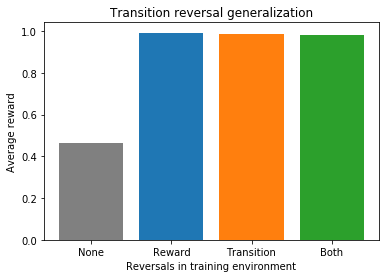

In [31]:
x = np.arange(4)
plt.bar(x,transition_generalization_results, color=['gray','tab:blue','tab:orange','tab:green'])
plt.xticks(x,['None','Reward', 'Transition', 'Both'])
plt.title('Transition reversal generalization')
plt.ylabel('Average reward')
plt.xlabel('Reversals in training environment')
plt.show()

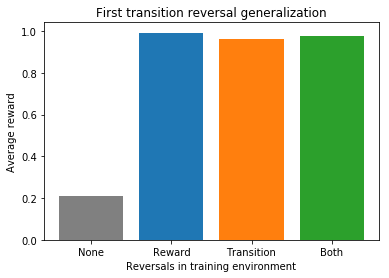

In [32]:
x = np.arange(4)
plt.bar(x,first_transition_generalization_results, color=['grey','tab:blue','tab:orange','tab:green'])
plt.xticks(x,['None','Reward', 'Transition', 'Both'])
plt.title('First transition reversal generalization')
plt.ylabel('Average reward')
plt.xlabel('Reversals in training environment')
plt.show()

TODO: build special tests to investigate what is being held in the LSTM's memory - i.e. can we decode the likely future state (evidence of planning?), does the model update its policy in response to changes in reward, changes in transition structure, or both?
* Idea: the lazy policy, where you only keep track of the variables that are relevant to the task at hand (in this case, the one latent variable that can describe the reward structure, the transition structure, or both), is optimal in the rocket task. This emphasizes the over-structured nature of the reinforcement learning models normally used in neuroscience, and emphasizes the power of having a flexible algorithm that meta-learns over time how to best manage its own resources.

### Interpretation of results in metaRL framework

Models of human reinforcement learning:
* Model-free (learn value function only)
    * Fails on reward reversal generalization
    * Fails on transition reversal generalization
* Model-based (learn transition structure and immediate reward function)
    * Succeeds on reward reversal generalization
    * Fails on transition reversal generalization
* Successor representation (learn SR matrix and immediate reward function)
    * Succeeds on reward reversal generalization
    * Fails on transition reversal generalization
* Cluster-SR (learn SR, cluster states based on SR, and share value-learning within clusters)
    * Succeeds on reward reversal generalization
    * Succeeds on transition reversal generalization after enough experience with transition structure
* Meta-reinforcement learning LSTM
    * Succeeds on reward reversal generalization
    * Succeeds on transition reversal generalization

Results from the behavioral experiment with the rocket task:
1. Participants showed evidence of model-based control in their ability to generalize after reward reversals
    * MetaRL model shows evidence of model-based control when trained on reward reversals in both the modified rocket task used in the behavioral experiment and the Daw two-step task
2. Effect of experiment phase: participants did not naturally generalize after transition reversals in the beginning of the experiment, but they did do so if they received the transition reversals after experience with reward reversals
    * Model trained on reward reversals generalizes after transition reversals, without having seen them
    * This is pretty good, because it captures the surprising finding that experience with reward reversals improves performance on transition reversal generalization trials. However, in order to fully account for all of the behavioral findings, we would need a model that:
        1. Generalizes on reward reversals without having seen any (i.e. naturally model-based)
        2. Does not generalize on transition reversals without having seen any (i.e. does not make the assumption that when one rocket changes where it's going, the other will as well)
        3. Generalizes on transition reversals after having experience with reward reversals (already shown in experiments above)
        4. Generalizes on reward reversals, after having been trained on transiton reversals (already shown in experiments above)
            * In behavioral experiment, participants actually did worse on reward reversal generalization after having seen transition reversals, but this was probably just due to being confused/discouraged after not getting the transition reversal stuff. 

Overall takeaway: Traditional reinforcement learning models are psychologically unrealistic in that they don't model the cognitive cost of maintaining and updating an estimate of the dynamics of a new environment. MetaRL is a good model of cognitive resource management in humans because it must maintain in working memory the variables required to learn a task in real time. Furthermore, metaRL shows evidence of "lazy" state aggregation, and maintains only the minimum amount of information to perform a task well.

## Temporal abstraction

### Experiments with rooms environment

#### Environment

In [33]:
def sample_grid(grid):
    xs,ys = np.nonzero(grid)
    num_locations = xs.shape[0]
    rand = np.random.randint(0,num_locations)
    sample_location = (xs[rand],ys[rand])
    return sample_location

class Rocket_task():
    def __init__(self,p_reversal_dist=[0.025,0.025],
                      p_reward_reversal_dist=[0.5,0.5]):
        self.state_dim = 6
        self.action_dim = 2
        self.p_reversal_dist = p_reversal_dist
        self.p_reward_reversal_dist = p_reward_reversal_dist

    def sample(self):
        p_reversal = np.random.uniform(self.p_reversal_dist[0],
                                       self.p_reversal_dist[1])
        p_reward_reversal = np.random.uniform(self.p_reward_reversal_dist[0],
                                              self.p_reward_reversal_dist[1])
        env = Rocket_env(p_reversal,p_reward_reversal)
        return env

class Rooms_grid_env():
    def __init__(self,grid,reward_location=(1,1)):
        self.grid = grid
        self.reward_location = reward_location
        # Generate dictionary for converting locations to states
        xs,ys = np.nonzero(self.grid)
        num_locs = xs.shape[0]
        self.locs_to_states = {(xs[i],ys[i]):np.eye(num_locs)[i,:] for i in range(num_locs)}
    def init_new_trial(self):
        random_state_loc = sample_grid(self.grid)
        self.state_loc = random_state_loc
        self.state = self.locs_to_states[random_state_loc]
        self.done = False
    def step(self,action):
        if self.done:
            print("Need to reinitialize trial before taking another step")
            return
        # Get new location
        if action == 0: # Move down
            new_loc = (self.state_loc[0]+1, self.state_loc[1])
        elif action == 1: # Move up
            new_loc = (self.state_loc[0]-1, self.state_loc[1])
        elif action == 2: # Move left
            new_loc = (self.state_loc[0], self.state_loc[1]-1)
        elif action == 3: # Move right
            new_loc = (self.state_loc[0], self.state_loc[1]+1)
        # Can't go through walls
        if self.grid[new_loc[0],new_loc[1]] == 1:
            self.state_loc = new_loc
        else:
            self.state_loc = self.state_loc # stay in the same location
        # Get new state
        self.state = self.locs_to_states[self.state_loc]
        # Reward
        if self.state_loc == self.reward_location:
            reward = 1
            self.done = True
        else:
            reward = -0.01
        return self.state, reward, self.done
    def visualize(self):
        grid_with_reward = self.grid.copy()
        grid_with_reward[self.reward_location[0],self.reward_location[1]] = 2
        plt.imshow(grid_with_reward)
        plt.show()

class Rooms_grid_task():
    def __init__(self,room_size=3):
        self.state_dim = 4*room_size**2 + 4
        self.action_dim = 4
        assert room_size % 2 == 1, "Room size must be odd"
        self.room_size = room_size

        # Build grid
        grid = np.zeros([2*room_size+3,2*room_size+3])
        grid[1:room_size+1,1:room_size+1] = 1 # room1
        grid[room_size+2:2*room_size+2,1:room_size+1] = 1 # room2
        grid[1:room_size+1,room_size+2:2*room_size+2] = 1 # room3
        grid[room_size+2:2*room_size+2,room_size+2:2*room_size+2] = 1 # room4
        one_quarter = int((room_size+1)/2)
        grid_center = room_size+1
        three_quarters = grid_center + one_quarter
        grid[grid_center,one_quarter] = 1 # hall 1-2
        grid[one_quarter,grid_center] = 1 # hall 1-3
        grid[three_quarters,grid_center] = 1 # hall 2-4
        grid[grid_center,three_quarters] = 1 # hall 3-4
        self.grid = grid
    def sample(self):
        reward_location = sample_grid(self.grid)
        env = Rooms_grid_env(self.grid,reward_location)
        return env

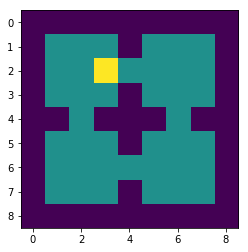

In [34]:
rooms_grid_task = Rooms_grid_task()
rooms_grid_env = rooms_grid_task.sample()
rooms_grid_env.init_new_trial()
rooms_grid_env.visualize()

#### Training

In [35]:
# Load training results
with open('results/train_rooms.json','r') as f:
    train_rooms = json.load(f)
train_rooms = train_rooms['total_rewards']

In [36]:
train_rooms_smooth = savgol_filter(train_rooms, 3001, 3)

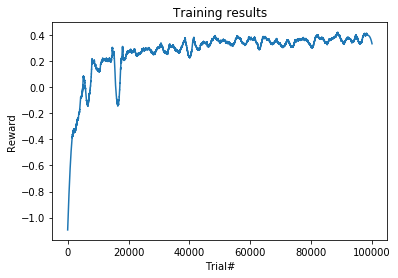

In [37]:
plt.plot(train_rooms_smooth)
plt.title('Training results')
plt.xlabel('Trial#')
plt.ylabel('Reward')
plt.show()

#### Testing

In [38]:
# Load testing results
test_rooms = np.load('results/test_rooms.npy')
# Setup pandas dataframe
col_names = ['Episode','Trial','T','State_row','State_col','Action',
             'Reward','Reward_location_row','Reward_location_col']
rooms_df = pd.DataFrame(test_rooms,columns=col_names)

Build dataframe

In [39]:
rooms_trial_df = pd.DataFrame(rooms_df.loc[(rooms_df['T'] == 1.0)])

Find number of steps taken on each trial

In [40]:
steps_i = (rooms_trial_df.index - 1)[1:] # Get indices of all timesteps before T = 1
steps_i = steps_i.append(pd.Index([rooms_df.index[len(rooms_df)-1]])) # Add index of last timestep
rooms_trial_df['Steps'] = np.array(rooms_df.iloc[steps_i]['T']) # Add column indicating number of steps in trial

Find minimium number of steps possible in each trial

In [41]:
# Build edge matrix
grid = rooms_grid_env.grid
xs,ys = np.nonzero(grid)
T = np.zeros([40,40]) # Matrix indicating whether cell i is 1 away from cell j
for i,(sx,sy) in enumerate(zip(xs,ys)):
    for j,(rx,ry) in enumerate(zip(xs,ys)):
        x_diff = np.abs(sx - rx) 
        y_diff = np.abs(sy - ry)
        if x_diff + y_diff == 1:
            T[i,j] = 1

In [42]:
distances = np.eye(40) - 1
T_i = T.copy()
not_filled = distances < 0
distances = distances + ((2*T_i) * not_filled)
for i in range(2,13):
    T_i = np.matmul(T_i,np.transpose(T)) > 0
    not_filled = distances < 0
    distances = distances + (((i+1)*T_i) * not_filled)

Random state location:  (5,7)


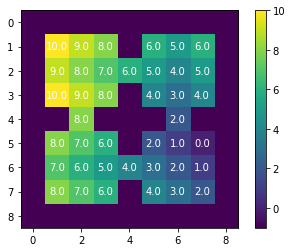

In [43]:
# Plot random row of distance matrix onto rooms grid to check accuracy
distance_grid = grid.copy() - 1
random_state = np.random.randint(40)
print('Random state location: ', '(%d,%d)' % (xs[random_state],ys[random_state]))
for row,col,d in zip(xs,ys,distances[random_state,:]):
    distance_grid[row,col] = d
plt.imshow(distance_grid)
for i in range(9):
    for j in range(9):
        if distance_grid[i,j] >= 0:
            text = plt.text(j, i, distance_grid[i, j],
                            ha="center", va="center", color="w")
plt.colorbar()
plt.show()

Add minimum number of steps to dataframe

In [44]:
locs_to_i = {(row,col):i for i,(row,col) in enumerate(zip(xs,ys))}
for i in rooms_trial_df.index:
    s_row, s_col = rooms_trial_df['State_row'][i], rooms_trial_df['State_col'][i]
    r_row, r_col = rooms_trial_df['Reward_location_row'][i], rooms_trial_df['Reward_location_col'][i]
    s_i,r_i = locs_to_i[(s_row,s_col)], locs_to_i[(r_row,r_col)]
    min_steps = distances[s_i,r_i]
    rooms_trial_df.loc[i,'Minimum steps'] = min_steps

Compute (number of steps - minimum number of steps) for all trials

In [45]:
first_trials_only_df = rooms_trial_df.loc[(rooms_trial_df['Trial'] == 0.0)]
no_first_trials_df = rooms_trial_df.loc[(rooms_trial_df['Trial'] != 0.0)]
average_steps_over_first = np.mean(first_trials_only_df['Steps'] - first_trials_only_df['Minimum steps'])
average_steps_over_not_first = np.mean(no_first_trials_df['Steps'] - no_first_trials_df['Minimum steps'])
print("Average number of steps over minimum in first trial of each episode", average_steps_over_first)
print("Average number of steps over minimum in all other trials", average_steps_over_not_first)

Average number of steps over minimum in first trial of each episode 0.0
Average number of steps over minimum in all other trials 197.86934673366835


#### Visualizing hidden states

Hidden states of randomly initialized model for comparison

In [46]:
# Load hidden states
rooms_h_random = np.load('results/rooms_hidden_states_random.npy')
# Get state locations and hidden states
state_locs = [(rooms_h_random[i,0], rooms_h_random[i,1]) for i in range(len(rooms_h_random))]
h_random = rooms_h_random[:,2:]

In [47]:
# Multidimensional scaling to visualize hidden states
embedding_random = MDS(n_components=2)
h_random_mds = embedding_random.fit_transform(h_random)

Map of rooms for determining color in scatterplots:
* Room 1 (top left): blue
* Room 2 (top right): red
* Room 3 (bottom left): yellow
* Room 4 (bottom right): black

Map of halls for determining color in scatterplots:
* Hall 1-2: purple
* Hall 1-3: green
* Hall 2-4: dark red
* Hall 3-4: brown

In [48]:
# Map of rooms for determining color in scatterplots
color_map = {}
for row,col in state_locs:
    if row < 4 and col < 4: # Room 1
        color_map[(row,col)] = 'blue'
    elif row < 4 and col > 4: # Room 2
        color_map[(row,col)] = 'red'
    elif row > 4 and col < 4: # Room 3
        color_map[(row,col)] = 'gold'
    elif row > 4 and col > 4: # Room 4
        color_map[(row,col)] = 'grey'
    elif row < 4 and col == 4: # Hall 1-2
        color_map[(row,col)] = 'purple'
    elif row == 4 and col < 4: # Hall 1-3
        color_map[(row,col)] = 'green'
    elif row == 4 and col > 4: # Hall 2-4
        color_map[(row,col)] = 'darkred'
    elif row > 4 and col == 4: # Hall 3-4
        color_map[(row,col)] = 'saddlebrown'

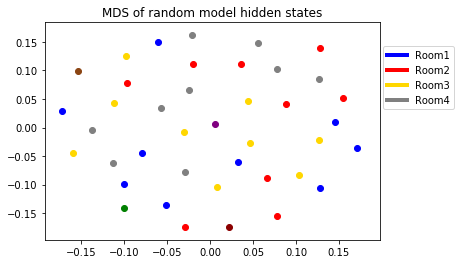

In [50]:
# Use invisible lines to hack the legend
invisible_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='gold', lw=4),
                Line2D([0], [0], color='grey', lw=4)]

# Plot results of MDS for randomly initialized model
for i,(row,col) in enumerate(state_locs):
    color = color_map[(row,col)]
    plt.scatter(h_random_mds[i,0], h_random_mds[i,1], c=color)
plt.legend(invisible_lines,['Room1','Room2','Room3','Room4'],loc=[1.01,0.6],prop={'size': 10})
plt.title('MDS of random model hidden states')
plt.show()

Hidden states of trained model

In [51]:
# Load hidden states
rooms_h = np.load('results/rooms_hidden_states.npy')
# Get state locations and hidden states
state_locs = [(rooms_h[i,0], rooms_h[i,1]) for i in range(len(rooms_h))]
h = rooms_h[:,2:]

In [52]:
# Multidimensional scaling to visualize hidden states
embedding = MDS(n_components=2)
h_mds = embedding.fit_transform(h)
# TODO: PCA
# TODO: t-SNE
# TODO: Euclidean distance matrix of hidden states

Map of rooms for determining color in scatterplots:
* Room 1 (top left): blue
* Room 2 (top right): red
* Room 3 (bottom left): yellow
* Room 4 (bottom right): black

Map of halls for determining color in scatterplots:
* Hall 1-2: purple
* Hall 1-3: green
* Hall 2-4: dark red
* Hall 3-4: brown

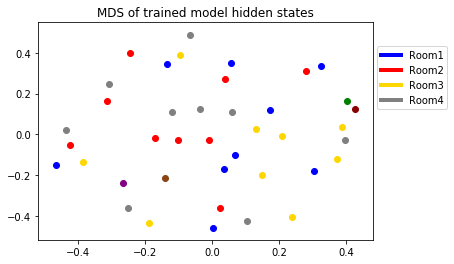

In [54]:
# Use invisible lines to hack the legend
invisible_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='gold', lw=4),
                Line2D([0], [0], color='grey', lw=4)]

# Plot results of MDS for trained model
for i,(row,col) in enumerate(state_locs):
    color = color_map[(row,col)]
    plt.scatter(h_mds[i,0], h_mds[i,1], c=color)
plt.legend(invisible_lines,['Room1','Room2','Room3','Room4'],loc=[1.01,0.6],prop={'size': 10})
plt.title('MDS of trained model hidden states')
plt.show()

<font color = 'red'> Figure out why model is failing at test time. Since it's doing well during training, it must be because it depends on small weight changes during each episode (i.e. putting itself into an area in weight space where small weight changes can do all of the work for changing the policy.)

<font color = 'red'>

Should retrain using less trials per episode.

Can also try:
* Annealing the learning rate?
* Adding random actions with probability epsilon?
* Doing asynchronous updates so that catastrophic forgetting is not a problem (i.e. the whole point of A3C in the first place)
    * Have to get multiple cpu threads, each with its own copy of the model and the environment
    * Figure out how to synchronize the updates

<font color = 'red'> 
TODO:
* Try running model with "pondering" time at each step?
    * How to analyze the representations that emerge when pondering is allowed?
* Can show that all of the behavioral/neuroscientific findings suggesting the existence of the successor representation can be explained in the metaRL framework (e.g. behavioral experiments from Gershman lab)?
* Meta-RL system can learn to plan combinatorially?
    * Comapre to options framework, which can recursively combine actions and options into new options

## Biological detail

General thoughts on biological plausibility of meta-reinforcement learning model
* LSTM is a somewhat biologically plausible model of the PFC-BG recurrent system?
    * Are the inputs (state, previous action, previous reward) biologically plausible?
        * Can try having separate components, each of which is a recurrent network?
* Learning rule:
    * DA for predicting value of states: same principle as is used in PVLV?
    * DA for training actor (i.e. policy loss): 
        * If state has higher value than expected (i.e. dopamine burst), then update the policy to make the action that was just taken more likley. 
        * If state has lower value than expected (i.e. dopamine dip), then update the policy to make the action was just taken less likely.
    * Entropy loss: essentially just encourages exploration, could replace with other ways of encouraging exploration, e.g. temperature parameter of softmax, episolon-greedy, etc.